In [52]:
import warnings

import numpy as np
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
import scikit_posthocs as sp
import seaborn as sns
import statsmodels.api as sm
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import levene, tukey_hsd
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings("ignore")

In [27]:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

In [28]:
data = pd.read_csv('ds_salaries.csv', index_col=0)
data = data.astype({"work_year": str, "remote_ratio": str})

In [29]:
data['remote_ratio'].replace(['100', '50', '0'], ['Remote', 'Hybrid', 'On-site'], inplace=True)
data['experience_level'].replace(['EN', 'MI', 'SE', 'EX'],
                                 ['Entry-level', 'Mid-level', 'Senior-level', 'Executive-level'], inplace=True)
data['employment_type'].replace(['FT', 'PT', 'CT', 'FL'], ['Full-time', 'Part-time', 'Contract', 'Freelance'],
                                inplace=True)
data['company_size'].replace(['L', 'M', 'S'], ['Large', 'Medium', 'Small'], inplace=True)

In [30]:
country_currency = {
    'DE': 'EUR',
    'JP': 'JPY',
    'GB': 'GBP',
    'HN': 'HNL',
    'US': 'USD',
    'HU': 'HUF',
    'NZ': 'NZD',
    'FR': 'EUR',
    'IN': 'INR',
    'PK': 'PKR',
    'PL': 'PLN',
    'PT': 'EUR',
    'CN': 'CNY',
    'GR': 'EUR',
    'AE': 'AED',
    'NL': 'EUR',
    'MX': 'MXN',
    'CA': 'CAD',
    'AT': 'EUR',
    'NG': 'NGN',
    'PH': 'PHP',
    'ES': 'EUR',
    'DK': 'DKK',
    'RU': 'RUB',
    'IT': 'EUR',
    'HR': 'HRK',
    'BG': 'BGN',
    'SG': 'SGD',
    'BR': 'BRL',
    'IQ': 'IQD',
    'VN': 'VND',
    'BE': 'EUR',
    'UA': 'UAH',
    'MT': 'EUR',
    'CL': 'CLP',
    'RO': 'RON',
    'IR': 'IRR',
    'CO': 'COP',
    'MD': 'MDL',
    'KE': 'KES',
    'SI': 'SIT',
    'HK': 'HKD',
    'TR': 'TRY',
    'RS': 'RSD',
    'PR': 'USD',
    'LU': 'EUR',
    'JE': 'GBP',
    'CZ': 'CZK',
    'AR': 'ARS',
    'DZ': 'DZD',
    'TN': 'TND',
    'MY': 'MYR',
    'EE': 'EUR',
    'AU': 'AUD',
    'BO': 'BOB',
    'IE': 'EUR',
    'CH': 'CHF'
}

data['employee_residence_currency'] = data['employee_residence'].map(country_currency)

In [31]:
data['salary_comparison'] = data['salary'] / data['salary_in_usd']

list_1 = data[(data.salary_currency == data.employee_residence_currency)].index.tolist()
data.loc[list_1, 'country_currency_salary'] = 'Yes'
data['country_currency_salary'].fillna('No', inplace=True)

list_2 = data[(data.employee_residence == data.company_location)].index.tolist()
data.loc[list_2, 'home_country'] = 'Yes'
data['home_country'].fillna('No', inplace=True)

In [32]:
fig = make_subplots(rows=2, cols=3, specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}],
                                           [{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4", "Plot 5", "Plot 6"),
                    vertical_spacing=0.15,
                    horizontal_spacing=0.05)

fig.add_trace(go.Pie(labels=data['work_year'].value_counts().index,
                     values=data['work_year'].value_counts().values,
                     name="Work Year",
                     legendgroup="Work Year",
                     legendgrouptitle_text=f'<b>Work Year</b>'),
              1, 1)

fig.add_trace(go.Pie(labels=data['experience_level'].value_counts().index,
                     values=data['experience_level'].value_counts().values,
                     name="Experience Level",
                     legendgroup="Experience Level",
                     legendgrouptitle_text=f'<b>Experience Level</b>'),
              1, 2)

fig.add_trace(go.Pie(labels=data['employment_type'].value_counts().index,
                     values=data['employment_type'].value_counts().values,
                     name="Employment Type",
                     legendgroup="Employment Type",
                     legendgrouptitle_text=f'<b>Employment Type</b>'),
              1, 3)

fig.add_trace(go.Pie(labels=data['salary_currency'].value_counts().index,
                     values=data['salary_currency'].value_counts().values,
                     name="Salary Currency",
                     legendgroup="Salary Currency",
                     legendgrouptitle_text=f'<b>Salary Currency</b>'),
              2, 1)

fig.add_trace(go.Pie(labels=data['company_size'].value_counts().index,
                     values=data['company_size'].value_counts().values,
                     name="Company Size",
                     legendgroup="Company Size",
                     legendgrouptitle_text=f'<b>Company Size</b>'),
              2, 2)

fig.add_trace(go.Pie(labels=data['country_currency_salary'].value_counts().index,
                     values=data['country_currency_salary'].value_counts().values,
                     name="country_currency_salary",
                     legendgroup="Country Currency",
                     legendgrouptitle_text=f'<b>Country Currency</b>'),
              2, 3)

fig.update_traces(hole=.30, textposition='inside', hoverinfo='percent+label+name', textinfo='percent+label')

fig.update_layout(
    title_text="General View",
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    height=1000,
    margin={"l": 100, "r": 100, "t": 100, "b": 100},
    paper_bgcolor="rgb(225, 255, 248)"
)

names = {'Plot 1': 'Work Year', 'Plot 2': 'Experience Level', 'Plot 3': 'Employment Type', 'Plot 4': 'Salary Currency',
         'Plot 5': 'Company Size', 'Plot 6': 'Country Currency?'}

fig.for_each_annotation(lambda a: a.update(text=names[a.text]))
fig.update_annotations(font_size=16, font_color='Purple')
fig.show()

In [33]:
job_mapping = {
    'Data Scientist': 'Scientist',
    'Machine Learning Scientist': 'Scientist',
    'Big Data Engineer': 'Engineer',
    'Product Data Analyst': 'Analyst',
    'Machine Learning Engineer': 'Engineer',
    'Data Analyst': 'Analyst',
    'Lead Data Scientist': 'Scientist',
    'Business Data Analyst': 'Analyst',
    'Lead Data Engineer': 'Engineer',
    'Lead Data Analyst': 'Analyst',
    'Data Engineer': 'Engineer',
    'Data Science Consultant': 'Consultant',
    'BI Data Analyst': 'Analyst',
    'Director of Data Science': 'Manager',
    'Research Scientist': 'Scientist',
    'Machine Learning Manager': 'Manager',
    'Data Engineering Manager': 'Manager',
    'Machine Learning Infrastructure Engineer': 'Engineer',
    'ML Engineer': 'Engineer',
    'AI Scientist': 'Scientist',
    'Computer Vision Engineer': 'Engineer',
    'Principal Data Scientist': 'Scientist',
    'Data Science Manager': 'Manager',
    'Head of Data': 'Manager',
    '3D Computer Vision Researcher': 'Other',
    'Data Analytics Engineer': 'Engineer',
    'Applied Data Scientist': 'Scientist',
    'Marketing Data Analyst': 'Analyst',
    'Cloud Data Engineer': 'Engineer',
    'Financial Data Analyst': 'Analyst',
    'Computer Vision Software Engineer': 'Engineer',
    'Director of Data Engineering': 'Manager',
    'Data Science Engineer': 'Engineer',
    'Principal Data Engineer': 'Engineer',
    'Machine Learning Developer': 'Developer',
    'Applied Machine Learning Scientist': 'Scientist',
    'Data Analytics Manager': 'Manager',
    'Head of Data Science': 'Manager',
    'Data Specialist': 'Other',
    'Data Architect': 'Architect',
    'Finance Data Analyst': 'Analyst',
    'Principal Data Analyst': 'Analyst',
    'Big Data Architect': 'Architect',
    'Staff Data Scientist': 'Scientist',
    'Analytics Engineer': 'Engineer',
    'ETL Developer': 'Developer',
    'Head of Machine Learning': 'Manager',
    'NLP Engineer': 'Engineer',
    'Lead Machine Learning Engineer': 'Engineer',
    'Data Analytics Lead': 'Other',
}

data['job_type'] = data['job_title'].map(job_mapping)

In [34]:
company_continent = {
    'DE': 'Europe',
    'JP': 'Asia',
    'GB': 'Europe',
    'HN': 'North America',
    'US': 'North America',
    'HU': 'Europe',
    'NZ': 'Oceania',
    'FR': 'Europe',
    'IN': 'Asia',
    'PK': 'Asia',
    'CN': 'Asia',
    'GR': 'Europe',
    'AE': 'Asia',
    'NL': 'Europe',
    'MX': 'North America',
    'CA': 'North America',
    'AT': 'Europe',
    'NG': 'Africa',
    'ES': 'Europe',
    'PT': 'Europe',
    'DK': 'Europe',
    'IT': 'Europe',
    'HR': 'Europe',
    'LU': 'Europe',
    'PL': 'Europe',
    'SG': 'Asia',
    'RO': 'Europe',
    'IQ': 'Asia',
    'BR': 'South America',
    'BE': 'Europe',
    'UA': 'Europe',
    'IL': 'Asia',
    'RU': 'Europe',
    'MT': 'Europe',
    'CL': 'South America',
    'IR': 'Asia',
    'CO': 'South America',
    'MD': 'Europe',
    'KE': 'Africa',
    'SI': 'Europe',
    'CH': 'Europe',
    'VN': 'Asia',
    'AS': 'Oceania',
    'TR': 'Europe',
    'CZ': 'Europe',
    'DZ': 'Africa',
    'EE': 'Europe',
    'MY': 'Asia',
    'AU': 'Oceania',
    'IE': 'Europe',
    'PH': 'Asia',
    'BG': 'Europe',
    'HK': 'Asia',
    'RS': 'Europe',
    'PR': 'North America',
    'JE': 'Europe',
    'AR': 'South America',
    'TN': 'Africa',
    'BO': 'South America'
}

data['company_continent'] = data['company_location'].map(company_continent)
data['employee_continent'] = data['employee_residence'].map(company_continent)

In [35]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=("Plot 1", "Plot 2"),
                    vertical_spacing=0.15,
                    horizontal_spacing=0.05)

fig.add_trace(go.Pie(labels=data['company_location'].value_counts().index,
                     values=data['company_location'].value_counts().values,
                     name="Company Location",
                     legendgroup="Company Location",
                     legendgrouptitle_text=f'<b>Company Location</b>'),
              1, 1)

fig.add_trace(go.Pie(labels=data['company_continent'].value_counts().index,
                     values=data['company_continent'].value_counts().values,
                     name="Company Continent",
                     legendgroup="Company Continent",
                     legendgrouptitle_text=f'<b>Company Continent</b>'),
              1, 2)

fig.update_traces(hole=.30, textposition='inside', hoverinfo='percent+label+name', textinfo='percent+label')

fig.update_layout(
    title_text="Company's Country and Continent",
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    height=600,
    margin={"l": 100, "r": 100, "t": 100, "b": 100},
    paper_bgcolor="rgb(225, 255, 248)"
)

names = {'Plot 1': 'Company Location', 'Plot 2': 'Company Continent'}

fig.for_each_annotation(lambda a: a.update(text=names[a.text]))
fig.update_annotations(font_size=16, font_color='Purple')
fig.show()

In [36]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=("Plot 1", "Plot 2"),
                    vertical_spacing=0.15,
                    horizontal_spacing=0.05)

fig.add_trace(go.Pie(labels=data['employee_residence'].value_counts().index,
                     values=data['employee_residence'].value_counts().values,
                     name="Employee Residence",
                     legendgroup="Employee Residence",
                     legendgrouptitle_text=f'<b>Employee Residence</b>'),
              1, 1)

fig.add_trace(go.Pie(labels=data['employee_continent'].value_counts().index,
                     values=data['employee_continent'].value_counts().values,
                     name="Employee Continent",
                     legendgroup="Employee Continent",
                     legendgrouptitle_text=f'<b>Employee Continent</b>'),
              1, 2)

fig.update_traces(hole=.30, textposition='inside', hoverinfo='percent+label+name', textinfo='percent+label')

fig.update_layout(
    title_text="Employee's Country and Continent",
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    height=600,
    margin={"l": 100, "r": 100, "t": 100, "b": 100},
    paper_bgcolor="rgb(225, 255, 248)"
)

names = {'Plot 1': 'Employee Residence', 'Plot 2': 'Employee Continent'}

fig.for_each_annotation(lambda a: a.update(text=names[a.text]))
fig.update_annotations(font_size=16, font_color='Purple')
fig.show()

In [37]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=("Plot 1", "Plot 2"),
                    vertical_spacing=0.15,
                    horizontal_spacing=0.05)

fig.add_trace(go.Pie(labels=data['job_title'].value_counts().index,
                     values=data['job_title'].value_counts().values,
                     name="Job Title",
                     legendgroup="Job Title",
                     legendgrouptitle_text=f'<b>Job Title</b>'),
              1, 1)

fig.add_trace(go.Pie(labels=data['job_type'].value_counts().index,
                     values=data['job_type'].value_counts().values,
                     name="Job Type",
                     legendgroup="Job Type",
                     legendgrouptitle_text=f'<b>Job Type</b>'),
              1, 2)

fig.update_traces(hole=.30, textposition='inside', hoverinfo='percent+label+name', textinfo='percent+label')

fig.update_layout(
    title_text="Job Title and Type",
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    height=600,
    margin={"l": 100, "r": 100, "t": 100, "b": 100},
    paper_bgcolor="rgb(225, 255, 248)"
)

names = {'Plot 1': 'Job Title', 'Plot 2': 'Job Type'}

fig.for_each_annotation(lambda a: a.update(text=names[a.text]))
fig.update_annotations(font_size=16, font_color='Purple')
fig.show()

In [38]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=("Plot 1", "Plot 2"),
                    vertical_spacing=0.15,
                    horizontal_spacing=0.05)

fig.add_trace(
    go.Pie(labels=data[data['employee_residence'] != data['company_location']].remote_ratio.value_counts().index,
           values=data[data['employee_residence'] != data['company_location']].remote_ratio.value_counts().values,
           name="Remote Ratio",
           legendgroup="Remote Ratio (Different Country)",
           legendgrouptitle_text=f'<b>Remote Ratio (Different Country)</b>'),
    1, 1)

fig.add_trace(
    go.Pie(labels=data[data['employee_residence'] == data['company_location']].remote_ratio.value_counts().index,
           values=data[data['employee_residence'] == data['company_location']].remote_ratio.value_counts().values,
           name="Remote Ratio",
           legendgroup="Remote Ratio (Same Country)",
           legendgrouptitle_text=f'<b>Remote Ratio (Same Country)</b>'),
    1, 2)

fig.update_traces(hole=.30, textposition='inside', hoverinfo='percent+label+name', textinfo='percent+label')

fig.update_layout(
    title_text="Remote Ratio (Different Country vs. Same Country)",
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    height=600,
    margin={"l": 100, "r": 100, "t": 100, "b": 100},
    paper_bgcolor="rgb(225, 255, 248)"
)

names = {'Plot 1': 'Remote Ratio (Different Country)', 'Plot 2': 'Remote Ratio (Same Country)'}

fig.for_each_annotation(lambda a: a.update(text=names[a.text]))
fig.update_annotations(font_size=16, font_color='Purple')
fig.show()

In [39]:
figs = [
    px.scatter(
        data,
        x="salary_in_usd",
        y="experience_level",
        animation_frame=ac,
        size='salary_in_usd',
        hover_name='job_title',
        color='job_title',
        color_discrete_sequence=px.colors.qualitative.Dark24,
        template='simple_white',
        title="Salary Based On Experience Level"
    )
    for ac in ["work_year", "employment_type", "remote_ratio", "company_size"]
]

layout = figs[0].to_dict()["layout"]
layout.pop("updatemenus")
layout["sliders"] = []
frames = []
for i, f in enumerate(figs):
    slider = f.to_dict()["layout"]["sliders"]
    slider[0]["y"] = -0.2 * i
    slider[0]["x"] = 0
    slider[0]["len"] = 1

    layout["sliders"] += slider
    frames += f.frames

go.Figure(data=figs[0].data, frames=frames, layout=layout).update_layout(
    margin={"l": 30, "r": 100, "t": 50, "b": 50}, height=900, paper_bgcolor="#F9E5FF"
)

In [40]:
figs = [
    px.box(
        data,
        x="salary_in_usd",
        y="experience_level",
        animation_frame=ac,
        hover_name='experience_level',
        color='experience_level',
        color_discrete_sequence=px.colors.qualitative.Dark24,
        template='simple_white',
        title="Salary Based On Experience Level",
    )
    for ac in ["work_year", "employment_type", "remote_ratio", "company_size"]
]

layout = figs[0].to_dict()["layout"]
layout.pop("updatemenus")
layout["sliders"] = []
frames = []
for i, f in enumerate(figs):
    slider = f.to_dict()["layout"]["sliders"]
    slider[0]["y"] = -0.2 * i
    slider[0]["x"] = 0
    slider[0]["len"] = 1

    layout["sliders"] += slider
    frames += f.frames

go.Figure(data=figs[0].data, frames=frames, layout=layout).update_xaxes(showline=True, linewidth=5, linecolor='black',
                                                                        gridcolor='Black')
go.Figure(data=figs[0].data, frames=frames, layout=layout).update_yaxes(showline=True, linewidth=5, linecolor='black',
                                                                        gridcolor='Black')

go.Figure(data=figs[0].data, frames=frames, layout=layout).update_layout(
    margin={"l": 30, "r": 100, "t": 50, "b": 50}, height=900, paper_bgcolor="#F9E5FF"
)

In [41]:
figs = [
    px.box(
        data,
        x="salary_in_usd",
        y="job_type",
        animation_frame=ac,
        hover_name='job_type',
        color='job_type',
        color_discrete_sequence=px.colors.qualitative.Dark24,
        template='simple_white',
        title="Salary Based On Job Type",
    )
    for ac in ["work_year", "employment_type", "remote_ratio", "company_size"]
]

layout = figs[0].to_dict()["layout"]
layout.pop("updatemenus")
layout["sliders"] = []
frames = []
for i, f in enumerate(figs):
    slider = f.to_dict()["layout"]["sliders"]
    slider[0]["y"] = -0.2 * i
    slider[0]["x"] = 0
    slider[0]["len"] = 1

    layout["sliders"] += slider
    frames += f.frames

go.Figure(data=figs[0].data, frames=frames, layout=layout).update_xaxes(showline=True, linewidth=5, linecolor='black',
                                                                        gridcolor='Black')
go.Figure(data=figs[0].data, frames=frames, layout=layout).update_yaxes(showline=True, linewidth=5, linecolor='black',
                                                                        gridcolor='Black')

go.Figure(data=figs[0].data, frames=frames, layout=layout).update_layout(
    margin={"l": 30, "r": 100, "t": 50, "b": 50}, height=900, paper_bgcolor="#F9E5FF"
)

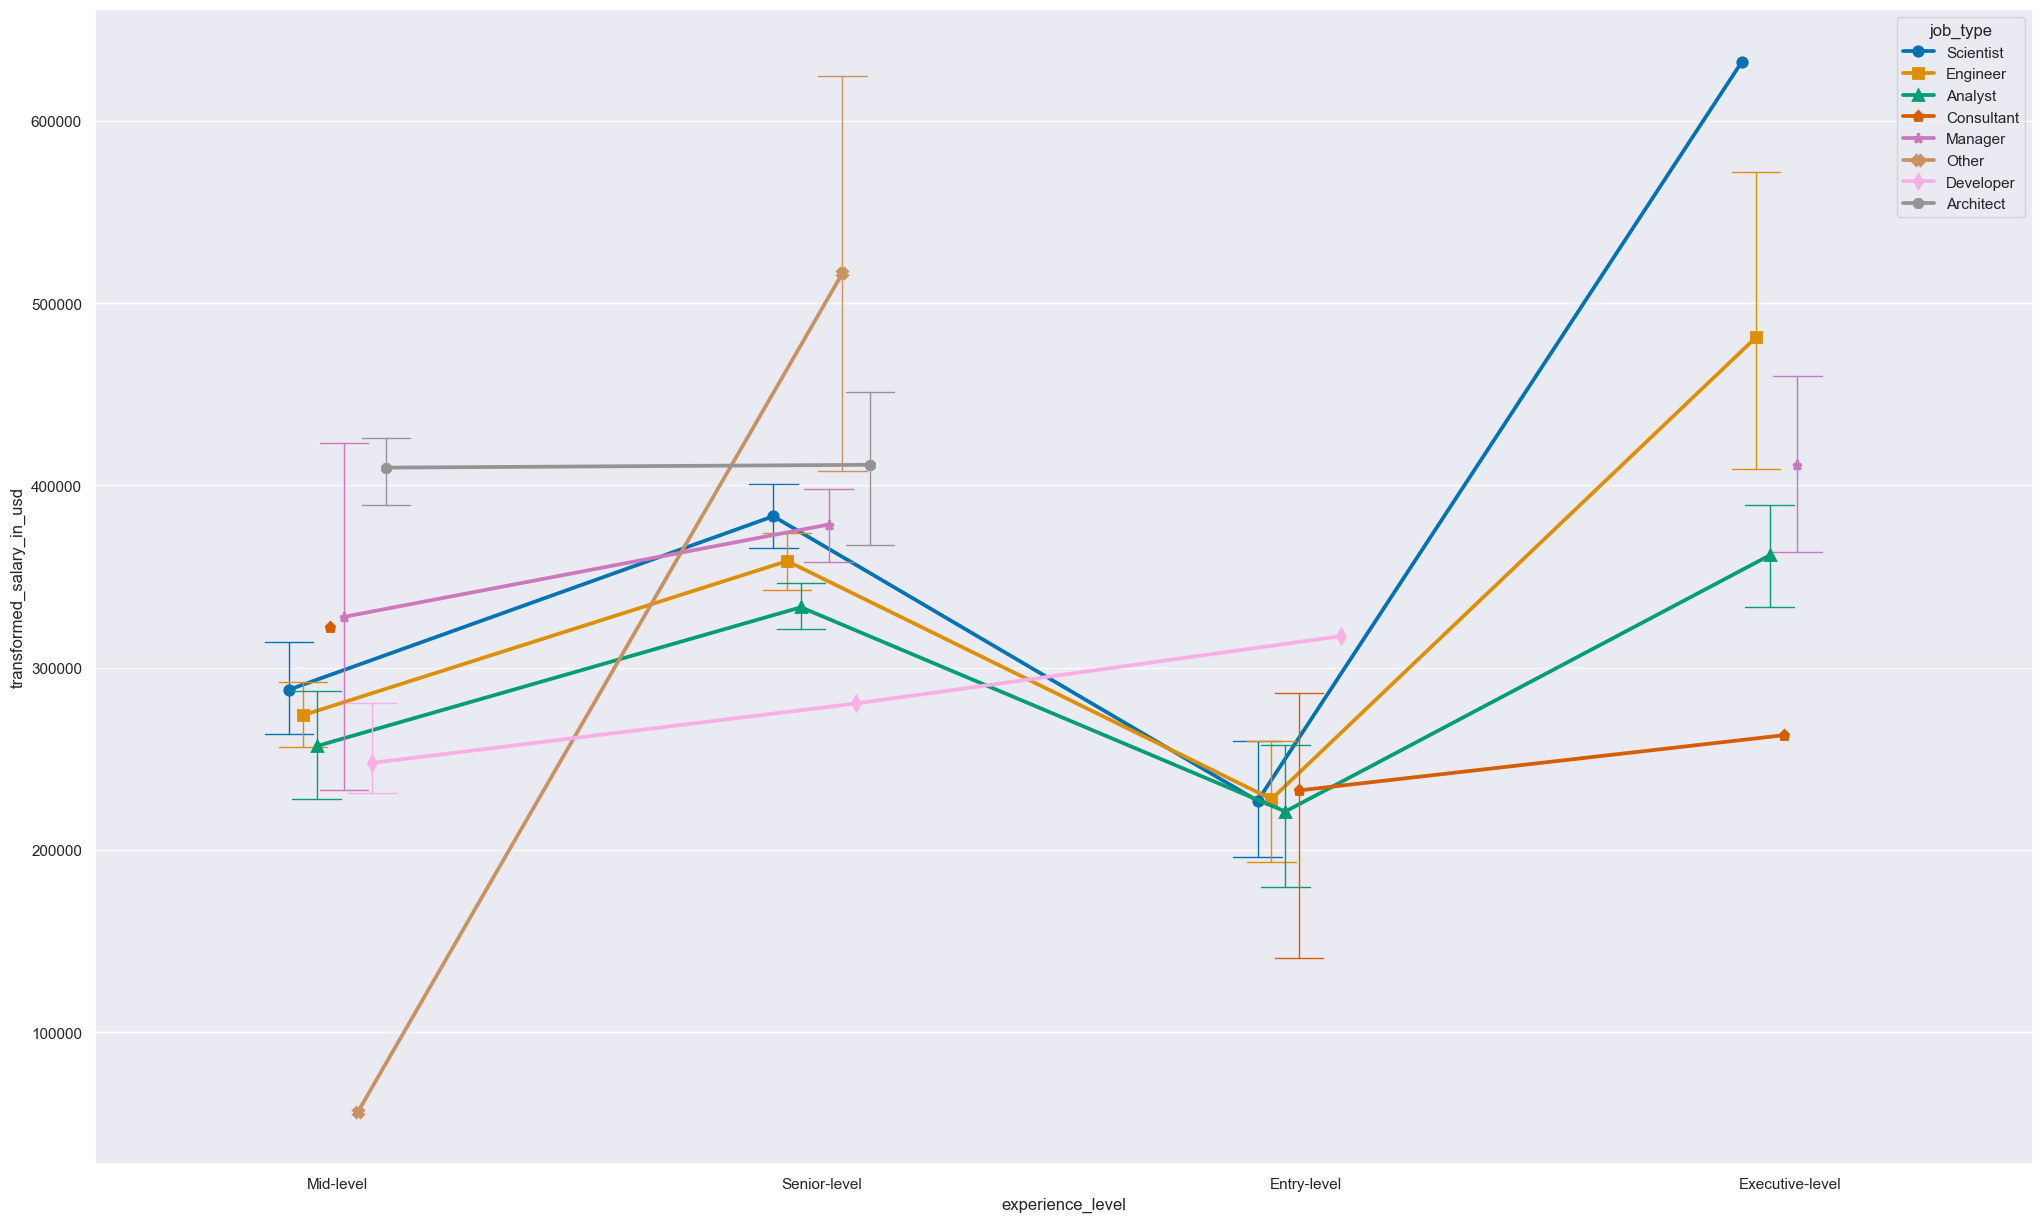

In [42]:
fitted_data, fitted_lambda = stats.boxcox(np.log(data['salary_in_usd']))
data['transformed_salary_in_usd'] = pd.Series(fitted_data)

sns.set(rc={"figure.figsize": (25, 15)})
sns.pointplot(data=data, x='experience_level', y='transformed_salary_in_usd', hue='job_type', dodge=True,
              markers=['o', 's', '^', 'p', '*', 'X', 'd', '8'],
              capsize=.1, errwidth=1, palette='colorblind');

In [43]:
model = ols('transformed_salary_in_usd ~ C(job_type) + C(experience_level) + C(job_type):C(experience_level)',
            data=data).fit()
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,"830,622,021,072.317",1.000,106.956,0.000
C(job_type),"151,177,238,387.942",7.000,2.781,0.007
C(experience_level),"248,685,057,518.362",3.000,10.674,0.000
C(job_type):C(experience_level),"464,090,820,172.430",21.000,2.846,0.000
Residual,"4,519,803,495,838.623",582.000,NaN,NaN


In [44]:
Analyst = data[data['job_type'] == 'Analyst']['transformed_salary_in_usd']
Architect = data[data['job_type'] == 'Architect']['transformed_salary_in_usd']
Consultant = data[data['job_type'] == 'Consultant']['transformed_salary_in_usd']
Developer = data[data['job_type'] == 'Developer']['transformed_salary_in_usd']
Engineer = data[data['job_type'] == 'Engineer']['transformed_salary_in_usd']
Manager = data[data['job_type'] == 'Manager']['transformed_salary_in_usd']
Scientist = data[data['job_type'] == 'Scientist']['transformed_salary_in_usd']
Other = data[data['job_type'] == 'Other']['transformed_salary_in_usd']

stat_jobtype, p_value_jobtype = levene(Analyst, Architect, Consultant, Developer, Engineer, Manager, Scientist, Other,
                                       center='median')
print('Job type levene test:', stat_jobtype, p_value_jobtype)

Midlevel = data[data['experience_level'] == 'Mid-level']['transformed_salary_in_usd']
Seniorlevel = data[data['experience_level'] == 'Senior-level']['transformed_salary_in_usd']
Entrylevel = data[data['experience_level'] == 'Entry-level']['transformed_salary_in_usd']
Executivelevel = data[data['experience_level'] == 'Executive-level']['transformed_salary_in_usd']

stat_experiencelevel, p_value_experiencelevel = levene(Midlevel, Seniorlevel, Entrylevel, Executivelevel,
                                                       center='median')
print('Experience level levene test:', stat_experiencelevel, p_value_experiencelevel)

Job type levene test: 4.959256840129098 1.809071821774051e-05
Experience level levene test: 3.897315985488385 0.008929686360844282


In [45]:
tukey = pairwise_tukeyhsd(endog=data['transformed_salary_in_usd'],
                          groups=data['job_type'],
                          alpha=0.01)
print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.01           
  group1     group2     meandiff   p-adj     lower        upper    reject
-------------------------------------------------------------------------
   Analyst  Architect  119330.2754 0.0043    7275.2314 231385.3194   True
   Analyst Consultant  -41839.1396 0.9697 -185726.4975 102048.2183  False
   Analyst  Developer  -23422.8088 0.9997 -192316.0328 145470.4152  False
   Analyst   Engineer   22582.5915 0.5473  -19417.1876  64582.3707  False
   Analyst    Manager   90887.5817    0.0   25611.5343 156163.6292   True
   Analyst      Other   71539.4628 0.9395 -144735.2149 287814.1406  False
   Analyst  Scientist   26948.1001 0.3427  -16130.1139  70026.3141  False
 Architect Consultant  -161169.415 0.0269 -337122.5559  14783.7259  False
 Architect  Developer -142753.0842 0.1692 -339681.6426  54175.4742  False
 Architect   Engineer  -96747.6839 0.0388 -206383.0681  12887.7003  False
 Architect    Manager  -28442.6937 0.9

In [46]:
sp.posthoc_scheffe(data, val_col='transformed_salary_in_usd', group_col='job_type')

,Scientist,Engineer,Analyst,Consultant,Manager,Other,Developer,Architect
Scientist,1.000,1.000,0.670,0.891,0.064,0.999,0.992,0.265
Engineer,1.000,1.000,0.821,0.920,0.029,0.999,0.996,0.203
Analyst,0.670,0.821,1.000,0.994,0.001,0.986,1.000,0.049
Consultant,0.891,0.920,0.994,1.000,0.205,0.928,1.000,0.162
Manager,0.064,0.029,0.001,0.205,1.000,1.000,0.613,0.998
Other,0.999,0.999,0.986,0.928,1.000,1.000,0.980,0.999
Developer,0.992,0.996,1.000,1.000,0.613,0.980,1.000,0.472
Architect,0.265,0.203,0.049,0.162,0.998,0.999,0.472,1.000


In [47]:
sp.posthoc_conover(data, val_col='transformed_salary_in_usd', group_col='job_type', p_adjust='bonferroni')

,Analyst,Architect,Consultant,Developer,Engineer,Manager,Other,Scientist
Analyst,1.000,0.001,1.000,1.000,0.931,0.000,1.000,0.399
Architect,0.001,1.000,0.009,0.048,0.012,1.000,1.000,0.022
Consultant,1.000,0.009,1.000,1.000,1.000,0.017,1.000,1.000
Developer,1.000,0.048,1.000,1.000,1.000,0.114,1.000,1.000
Engineer,0.931,0.012,1.000,1.000,1.000,0.000,1.000,1.000
Manager,0.000,1.000,0.017,0.114,0.000,1.000,1.000,0.001
Other,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
Scientist,0.399,0.022,1.000,1.000,1.000,0.001,1.000,1.000


In [48]:
sp.posthoc_tamhane(data, val_col='transformed_salary_in_usd', group_col='job_type')

,Scientist,Engineer,Analyst,Consultant,Manager,Other,Developer,Architect
Scientist,1.000,1.000,0.160,0.509,0.000,1.000,0.232,0.001
Engineer,1.000,1.000,0.268,0.575,0.000,1.000,0.308,0.001
Analyst,0.160,0.268,1.000,0.911,0.000,1.000,0.898,0.000
Consultant,0.509,0.575,0.911,1.000,0.047,0.999,1.000,0.014
Manager,0.000,0.000,0.000,0.047,1.000,1.000,0.003,0.813
Other,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000
Developer,0.232,0.308,0.898,1.000,0.003,1.000,1.000,0.000
Architect,0.001,0.001,0.000,0.014,0.813,1.000,0.000,1.000


In [49]:
pg.welch_anova(dv='transformed_salary_in_usd', between='job_type', data=data)

,Source,ddof1,ddof2,F,p-unc,np2
0,job_type,7,21.126,9.968,0.000,0.061


In [50]:
pg.pairwise_gameshowell(dv='transformed_salary_in_usd', between='job_type', data=data)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Analyst,Architect,"291,577.956","410,908.232","-119,330.275","19,258.410",-6.196,16.351,0.000,-1.357
1,Analyst,Consultant,"291,577.956","249,738.817","41,839.140","34,099.893",1.227,6.760,0.899,0.465
2,Analyst,Developer,"291,577.956","268,155.147","23,422.809","18,386.220",1.274,6.226,0.881,0.264
3,Analyst,Engineer,"291,577.956","314,160.548","-22,582.592","10,848.944",-2.082,277.733,0.429,-0.224
4,Analyst,Manager,"291,577.956","382,465.538","-90,887.582","14,275.332",-6.367,88.135,0.000,-1.046
5,Analyst,Other,"291,577.956","363,117.419","-71,539.463","165,841.019",-0.431,2.010,0.999,-0.739
6,Analyst,Scientist,"291,577.956","318,526.056","-26,948.100","11,666.774",-2.310,294.299,0.292,-0.253
7,Architect,Consultant,"410,908.232","249,738.817","161,169.415","37,402.308",4.309,9.392,0.025,2.164
8,Architect,Developer,"410,908.232","268,155.147","142,753.084","23,962.116",5.957,12.352,0.001,2.461
9,Architect,Engineer,"410,908.232","314,160.548","96,747.684","18,810.356",5.143,14.930,0.002,0.925


In [54]:
groups = [data[data['job_type'] == jb]['transformed_salary_in_usd'] for jb in data['job_type'].unique()]
th = tukey_hsd(*groups)

print(th)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)   4365.509     1.000-26802.344 35533.361
 (0 - 2)  26948.100     0.343-10016.837 63913.037
 (0 - 3)  68787.240     0.679-53347.803190922.283
 (0 - 4) -63939.482     0.006-116948.947-10930.017
 (0 - 5) -44591.363     0.996-229290.032140107.307
 (0 - 6)  50370.909     0.964-93420.460194162.278
 (0 - 7) -92382.175     0.060-186817.454  2053.104
 (1 - 0)  -4365.509     1.000-35533.361 26802.344
 (1 - 2)  22582.592     0.547-13456.952 58622.136
 (1 - 3)  64421.731     0.745-57436.428186279.890
 (1 - 4) -68304.990     0.002-120673.354-15936.626
 (1 - 5) -48956.871     0.993-233472.564135558.821
 (1 - 6)  46005.400     0.978-97550.860189561.661
 (1 - 7) -96747.684     0.039-190824.589 -2670.779
 (2 - 0) -26948.100     0.343-63913.037 10016.837
 (2 - 1) -22582.592     0.547-58622.136 13456.952
 (2 - 3)  41839.140     0.970-81629.004165307.283
 (2 - 4) -90887.582     0.

In [55]:
pg.pairwise_tukey(data=data, dv='transformed_salary_in_usd', between='job_type')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Analyst,Architect,"291,577.956","410,908.232","-119,330.275","31,611.994",-3.775,0.004,-1.357
1,Analyst,Consultant,"291,577.956","249,738.817","41,839.140","40,592.250",1.031,0.970,0.465
2,Analyst,Developer,"291,577.956","268,155.147","23,422.809","47,646.687",0.492,1.000,0.264
3,Analyst,Engineer,"291,577.956","314,160.548","-22,582.592","11,848.612",-1.906,0.547,-0.224
4,Analyst,Manager,"291,577.956","382,465.538","-90,887.582","18,415.111",-4.935,0.000,-1.046
5,Analyst,Other,"291,577.956","363,117.419","-71,539.463","61,013.531",-1.173,0.939,-0.739
6,Analyst,Scientist,"291,577.956","318,526.056","-26,948.100","12,152.851",-2.217,0.343,-0.253
7,Architect,Consultant,"410,908.232","249,738.817","161,169.415","49,638.369",3.247,0.027,2.164
8,Architect,Developer,"410,908.232","268,155.147","142,753.084","55,555.772",2.570,0.169,2.461
9,Architect,Engineer,"410,908.232","314,160.548","96,747.684","30,929.381",3.128,0.039,0.925
